# Exam Preparation: Curve Fitting

## Setup

In [1]:
import numpy as np
from scipy.stats import norm, ncx2, gamma
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# interpolation
from numpy.polynomial.hermite import hermfit, hermval
import copy

# Global settings for LaTeX rendering
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['mathtext.fontset'] = 'cm'

# local
import fixed_income_derivatives as fid

## Plot Term Structure of Spot Rates, Instantenous Forward Rates and Par Swap Rates

Plot the term structures of spot rates, instantaneous forward rates and par swap rates implied
by the fitted ZCB term structure.

Assume the following market data available where the interest rate swaps pay 6M EURIBOR semiannually against a fixed rate also paid semiannually.
$$
\begin{array}{|c|c|c|c|c|c|}
\hline \text { EURIBOR } & \text { Fixing } & \text { FRA } & \text { Midquote } & \text { IRS } & \text { Midquote } \\
\hline 6 \mathrm{M} & 0.03478 & 1 \mathrm{X} 7 & 0.03743 & 2 \mathrm{Y} & 0.04377 \\
& & \text { 2X8 } & 0.03871 & 3 \mathrm{Y} & 0.04625 \\
& & 3 \mathrm{X} 9 & 0.03989 & 4 \mathrm{Y} & 0.04777 \\
& & 4 \mathrm{X} 10 & 0.04098 & 5 \mathrm{Y} & 0.04875 \\
& & 5 \mathrm{X} 11 & 0.04198 & 7 \mathrm{Y} & 0.04992 \\
& & 6 \mathrm{X} 12 & 0.04289 & 10 \mathrm{Y} & 0.05081 \\
& & 7 \mathrm{X} 13 & 0.04374 & 15 \mathrm{Y} & 0.05148 \\
& & 8 \mathrm{X} 14 & 0.04452 & 20 \mathrm{Y} & 0.05181 \\
& & 9 \mathrm{X} 15 & 0.04524 & 30 \mathrm{Y} & 0.05211 \\
\hline
\end{array}
$$

Knot points are maturity of swaps, we need to choose these spot rates and interpolate rrest of curve and price asset in the market (swaps). If successful, we will have the entire ZCB spot rate curve. 

### Specify Market Data

Input from table:

In [2]:
# Known point
EURIBOR_fixing = [{"id": 0,"instrument": "libor","maturity": 1/2, "rate":0.03478}]

# Forward Rate Agreements
fra_market = [{"id": 1,"instrument": "fra","exercise": 1/12,"maturity": 7/12, "rate": 0.03743},
{"id": 2,"instrument": "fra","exercise": 2/12,"maturity": 8/12, "rate": 0.03871},
{"id": 3,"instrument": "fra","exercise": 3/12,"maturity": 9/12, "rate": 0.03989},
{"id": 4,"instrument": "fra","exercise": 4/12,"maturity": 10/12, "rate": 0.04098},
{"id": 5,"instrument": "fra","exercise": 5/12,"maturity": 11/12, "rate": 0.04198},
{"id": 6,"instrument": "fra","exercise": 6/12,"maturity": 12/12, "rate": 0.04289},
{"id": 7,"instrument": "fra","exercise": 7/12,"maturity": 13/12, "rate": 0.04374},
{"id": 8,"instrument": "fra","exercise": 8/12,"maturity": 14/12, "rate": 0.04452},
{"id": 9,"instrument": "fra","exercise": 9/12,"maturity": 15/12, "rate": 0.04524}]

# Knot points on longer maturities
swap_market = [{"id": 10,"instrument": "swap","maturity": 2, "rate": 0.04377, "float_freq": "semiannual", "fixed_freq": "semiannual","indices": []},
{"id": 11,"instrument": "swap","maturity": 3, "rate": 0.04625, "float_freq": "semiannual", "fixed_freq": "semiannual","indices": []},
{"id": 12,"instrument": "swap","maturity": 4, "rate": 0.04777, "float_freq": "semiannual", "fixed_freq": "semiannual","indices": []},
{"id": 13,"instrument": "swap","maturity": 5, "rate": 0.04875, "float_freq": "semiannual", "fixed_freq": "semiannual","indices": []},
{"id": 14,"instrument": "swap","maturity": 7, "rate": 0.04992, "float_freq": "semiannual", "fixed_freq": "semiannual","indices": []},
{"id": 15,"instrument": "swap","maturity": 10, "rate": 0.05081, "float_freq": "semiannual", "fixed_freq": "semiannual","indices": []},
{"id": 16,"instrument": "swap","maturity": 15, "rate": 0.05148, "float_freq": "semiannual", "fixed_freq": "semiannual","indices": []},
{"id": 17,"instrument": "swap","maturity": 20, "rate": 0.05181, "float_freq": "semiannual", "fixed_freq": "semiannual","indices": []},
{"id": 18,"instrument": "swap","maturity": 30, "rate": 0.05211, "float_freq": "semiannual", "fixed_freq": "semiannual","indices": []}]

In [3]:
data = EURIBOR_fixing + fra_market + swap_market
#print(data)

#### Known rates

In [4]:
# Known rates
#spot_rate[6] = np.log(1+L_6m*(T[6]-T[0]))/(T[6]-T[0])
#spot_rate[12] = (spot_rate[6]*(T[6]-T[0]) + fra_market_rates[5]*(T[12]-T[6]))/(T[12]-T[0])
L_6M = 0.03478
spot_rate_6M = np.log(1+L_6M*(data[0]["maturity"]-0))/(data[0]["maturity"]-0)
spot_rate_12M = (spot_rate_6M*(data[0]["maturity"]-0) + data[6]["rate"]*(data[6]["maturity"]-data[0]["maturity"]))/(data[6]["maturity"]-0)

### Linear Interpolation

In [5]:
# output ZC spot rate curve, R(t,T)
tau_fit_lin, R_fit_lin = fid.zcb_curve_fit(data,interpolation_options = {"method": "linear"})
#print(R_fit_lin)
#print(tau_fit_lin)

To include the instantenous forward rates, we can use the fact that we can go from spot rates --> ZCB --> forward rates:

In [6]:
ZCB_fit_lin = fid.spot_rates_to_zcb(tau_fit_lin,R_fit_lin)
f_fit_lin = fid.zcb_to_forward_rates(tau_fit_lin, ZCB_fit_lin, horizon = 0) # horizon 0 --> instantenous

Plot:

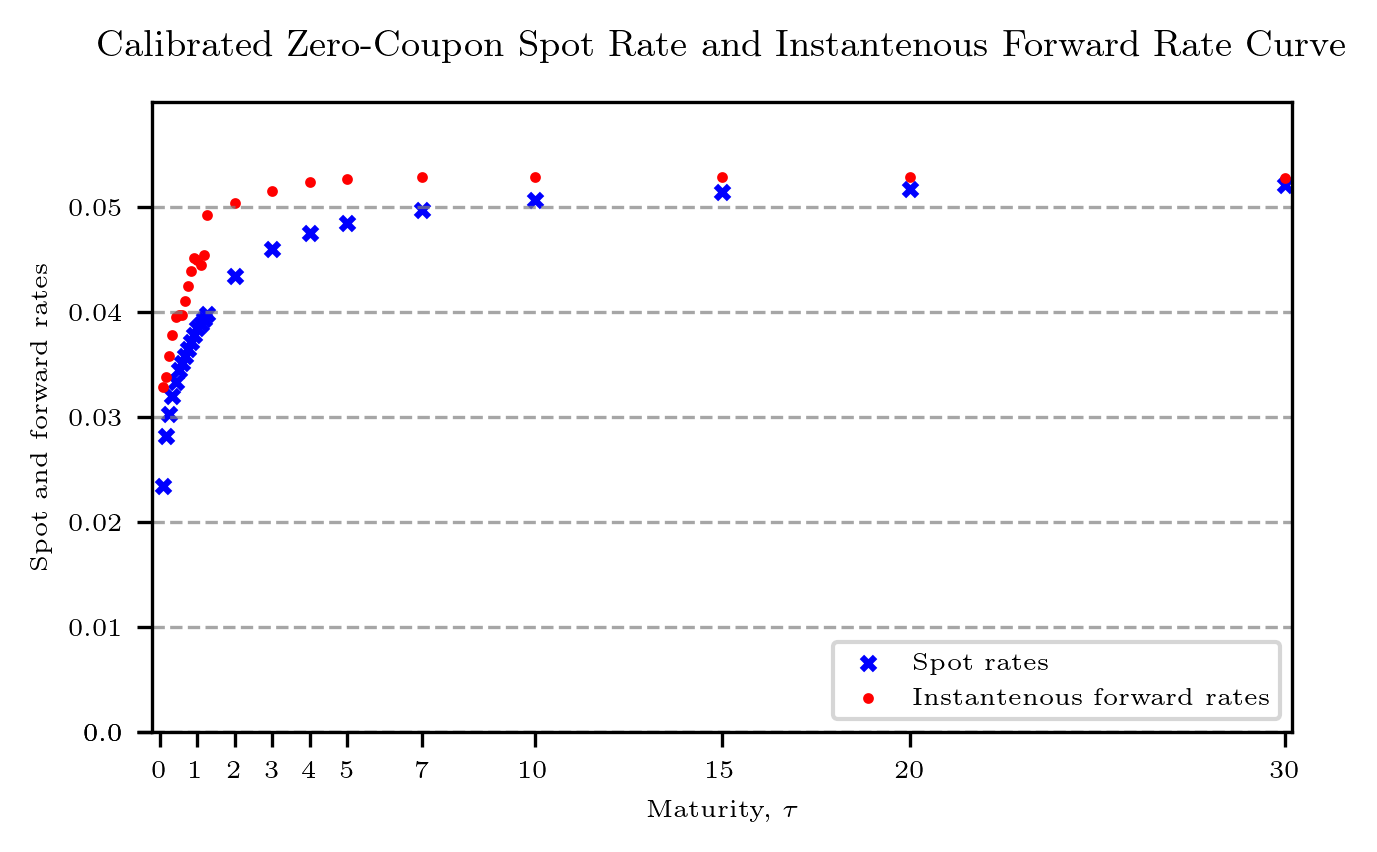

In [7]:
fig = plt.figure(constrained_layout=False, dpi = 300, figsize = (5,3))   #
fig.suptitle(f"Calibrated Zero-Coupon Spot Rate and Instantenous Forward Rate Curve", fontsize = 9)
gs = fig.add_gridspec(nrows=1,ncols=1,left=0.12,bottom=0.2,right=0.88,top=0.90,wspace=0,hspace=0)
ax = fig.add_subplot(gs[0,0])

xticks = [0,1,2,3,4,5,7,10,15,20,30]
ax.set_xticks(xticks)
ax.set_xticklabels(xticks,fontsize = 6)
ax.set_xlim([xticks[0]-0.2,xticks[-1]+0.2])
plt.xlabel(f"Maturity, $\\tau$",fontsize = 6)
ax.set_yticks([0,0.01,0.02,0.03,0.04,0.05,0.0])
ax.set_yticklabels([0,0.01,0.02,0.03,0.04,0.05,0.0],fontsize = 6)
ax.set_ylim([0,0.06])
ax.set_ylabel(f"Spot and forward rates",fontsize = 6)
ax.grid(axis='y', linestyle='--', color='grey', alpha=0.7)

p1 = ax.scatter(tau_fit_lin, R_fit_lin, s = 10, color = 'blue', marker = "x",label="Spot rates")
p2 = ax.scatter(tau_fit_lin, f_fit_lin, s = 10, color = 'red', marker = ".",label="Instantenous forward rates")

plots = [p1, p2]
labels = [item.get_label() for item in plots]
ax.legend(plots,labels,loc="lower right",fontsize = 6)
plt.show()

The quality of the resulting term structure should then be assessed and in particular, the term structure of the instantaneous forward rate should be computed using.
Note, because the spot rate is not differentiable, the term structure of forward rates will be discontinuous.

**Next, we apply a linear interpolation scheme:**

In [8]:
ZCB_price_inter_lin, R_inter_lin, f_inter_lin, tau_inter_lin = fid.zcb_curve_interpolate(tau_fit_lin,R_fit_lin,interpolation_options = {"method": "linear"},resolution = 1)

The par swap rate implied by the ZCB term structure can be found as: \
Input:
$T_n=$ Start time of the accrual period
$T_N=$ End time of the accrual period \
fixed freq $=$ Frequency of accrual
$T=$ time to maturity
$p=\mathrm{ZCB}$ price

Output:
$$
R=\text { Par swap rate }
$$

Formula:
$$
R_n^N(t)=\frac{p_n(t)-p_N(t)}{\sum_{i=n+1}^N \alpha_i p_i(t)}
$$
where $n$ is the start period and $N$ is the end period. Note that the denominator is the accrual rate.

**Note:** $R^{swap}$ should start at maturity of 1 year, since by construction value is zero for 6 month as they exchange 1 fixed for 1 floating.

In [9]:
# par swap rate "curve"
T_swap_lin = np.array([i for i in range(1, 31)])
S_swap_lin = np.zeros(len(T_swap_lin)) # allocate memory for accrual factor
R_swap_lin = np.zeros(len(T_swap_lin)) # allocate memory for par swap rate

for i, maturity in enumerate(T_swap_lin):
    S_swap_lin[i] = fid.zcb_to_accrual_factor(0,T_swap_lin[i], "semiannual", tau_inter_lin,ZCB_price_inter_lin)
    R_swap_lin[i] = fid.zcb_to_par_swap_rate(0,T_swap_lin[i],"semiannual", tau_inter_lin,ZCB_price_inter_lin) # first entry is begining but we could let it be forward starting swap, 

Plot results:

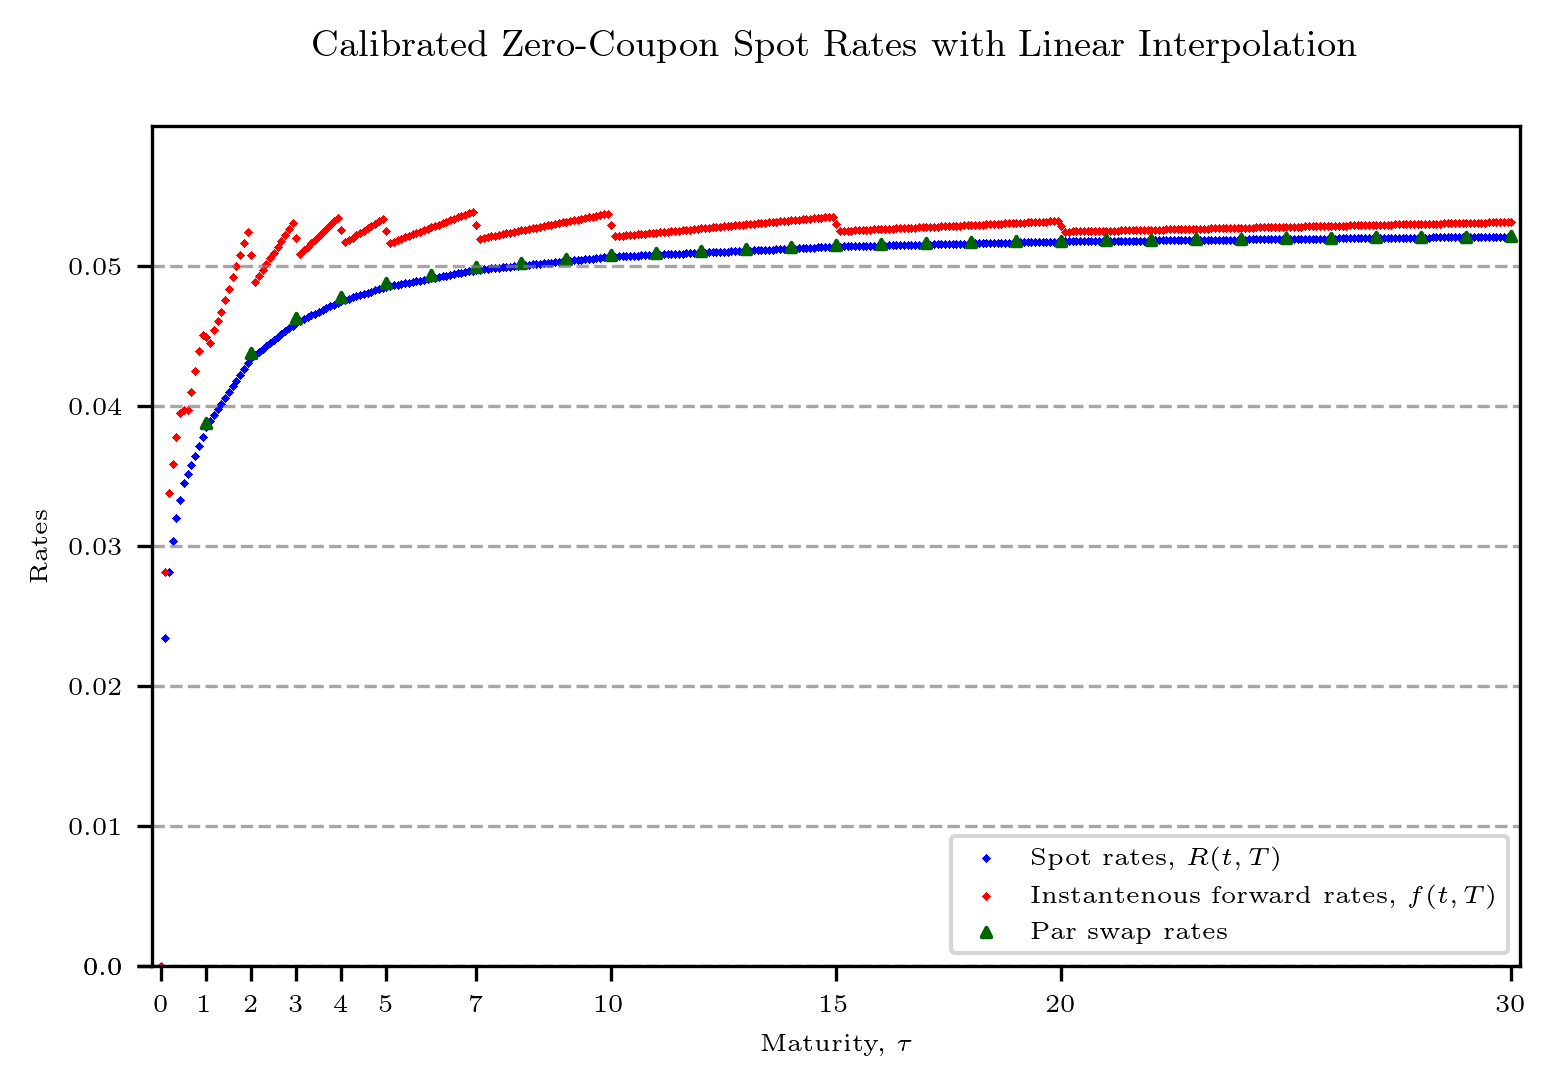

In [10]:
fig = plt.figure(constrained_layout=False, dpi = 300, figsize = (6,4))   #
fig.suptitle(f"Calibrated Zero-Coupon Spot Rates with Linear Interpolation", fontsize = 9)
gs = fig.add_gridspec(nrows=1,ncols=1,left=0.12,bottom=0.2,right=0.88,top=0.90,wspace=0,hspace=0)
ax = fig.add_subplot(gs[0,0])

xticks = [0,1,2,3,4,5,7,10,15,20,30]
ax.set_xticks(xticks)
ax.set_xticklabels(xticks,fontsize = 6)
ax.set_xlim([xticks[0]-0.2,xticks[-1]+0.2])
plt.xlabel(f"Maturity, $\\tau$",fontsize = 6)
ax.set_yticks([0,0.01,0.02,0.03,0.04,0.05,0.0])
ax.set_yticklabels([0,0.01,0.02,0.03,0.04,0.05,0.0],fontsize = 6)
ax.set_ylim([0,0.06])
ax.set_ylabel(f"Rates",fontsize = 6)
ax.grid(axis='y', linestyle='--', color='grey', alpha=0.7)


p1 = ax.scatter(tau_inter_lin, R_inter_lin, s=1, color = 'blue', marker = "x",label="Spot rates, $R(t,T)$")
p2 = ax.scatter(tau_inter_lin, f_inter_lin, s=1, color = 'red', marker = "x",label="Instantenous forward rates, $f(t,T)$")
p3 = ax.scatter(range(1,31), R_swap_lin, s=5, color = 'darkgreen', marker = "^", label="Par swap rates")

plots = [p1,p2,p3]
labels = [item.get_label() for item in plots]
ax.legend(plots,labels,loc="lower right",fontsize = 6)
plt.show()

* the forward rate curve is not at all continous, as it jumps at knot points. This hinges on the lack of differentiable spot rate curve, which was constructed using linear interpolatino, hence why we get the kinks at knot points. although zcb looks farily alright, but still room for improvement
* When plotting r_swap we cannot plot interpolated values.
* The par swap rate lies almost on top of spot rates, since ZCB and swaps are not all that different since intermediate cash flows tend to net out.

### Hermite Polynomial Interpolation

In [41]:
# output ZC spot rate curve, R(t,T)
tau_fit_hermite, R_fit_hermite = fid.zcb_curve_fit(data,interpolation_options = {"method": "hermite", "degree": 3})
#print(R_fit_hermite)
#print(tau_fit_hermite)

In [42]:
ZCB_fit_hermite = fid.spot_rates_to_zcb(tau_fit_hermite,R_fit_hermite)
f_fit_hermite = fid.zcb_to_forward_rates(tau_fit_hermite, ZCB_fit_hermite, horizon = 0) # horizon 0 --> instantenous

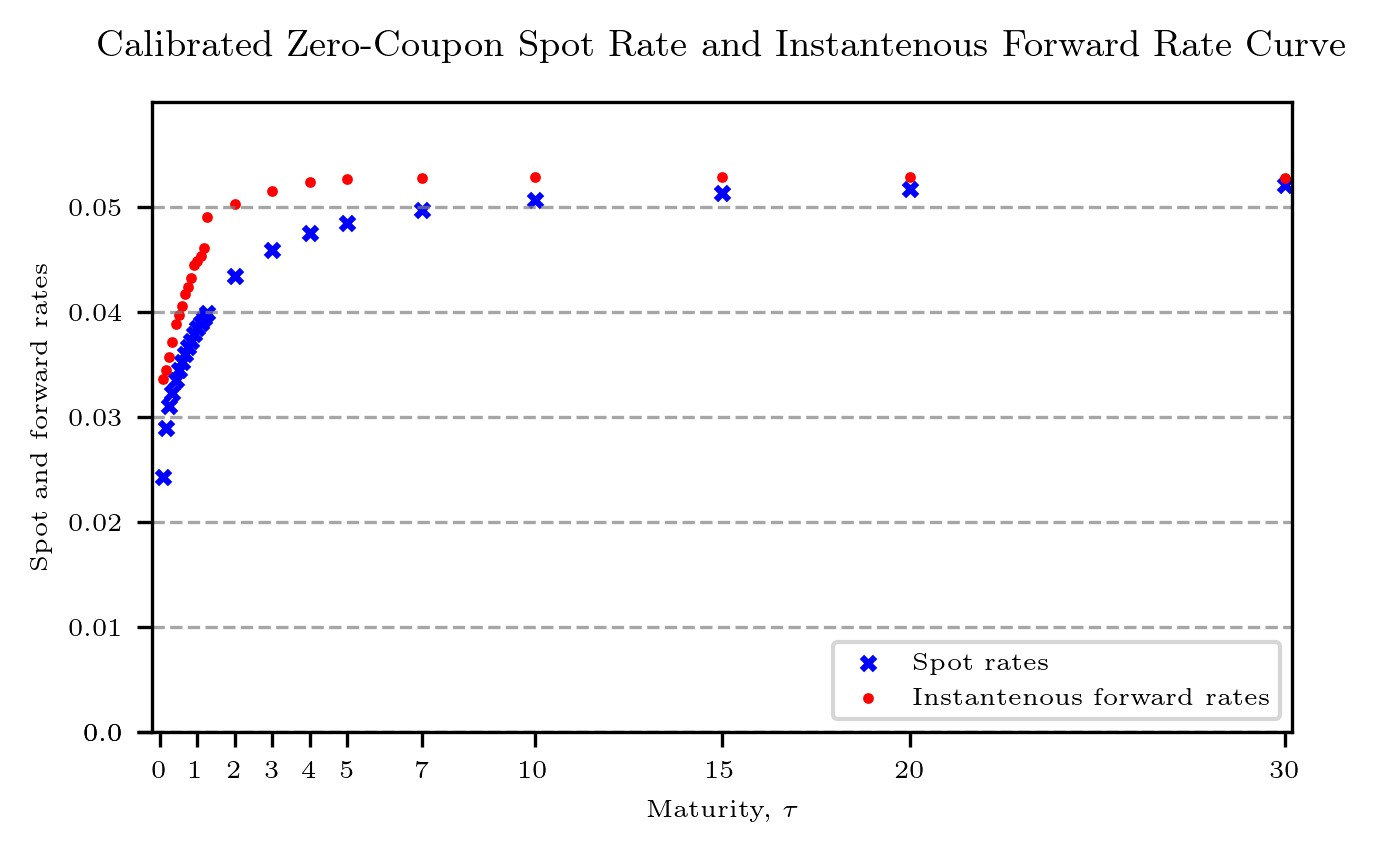

In [13]:
fig = plt.figure(constrained_layout=False, dpi = 300, figsize = (5,3))   #
fig.suptitle(f"Calibrated Zero-Coupon Spot Rate and Instantenous Forward Rate Curve", fontsize = 9)
gs = fig.add_gridspec(nrows=1,ncols=1,left=0.12,bottom=0.2,right=0.88,top=0.90,wspace=0,hspace=0)
ax = fig.add_subplot(gs[0,0])

xticks = [0,1,2,3,4,5,7,10,15,20,30]
ax.set_xticks(xticks)
ax.set_xticklabels(xticks,fontsize = 6)
ax.set_xlim([xticks[0]-0.2,xticks[-1]+0.2])
plt.xlabel(f"Maturity, $\\tau$",fontsize = 6)
ax.set_yticks([0,0.01,0.02,0.03,0.04,0.05,0.0])
ax.set_yticklabels([0,0.01,0.02,0.03,0.04,0.05,0.0],fontsize = 6)
ax.set_ylim([0,0.06])
ax.set_ylabel(f"Spot and forward rates",fontsize = 6)
ax.grid(axis='y', linestyle='--', color='grey', alpha=0.7)

p1 = ax.scatter(tau_fit_hermite, R_fit_hermite, s = 10, color = 'blue', marker = "x",label="Spot rates")
p2 = ax.scatter(tau_fit_hermite, f_fit_hermite, s = 10, color = 'red', marker = ".",label="Instantenous forward rates")

plots = [p1, p2]
labels = [item.get_label() for item in plots]
ax.legend(plots,labels,loc="lower right",fontsize = 6)
plt.show()

In [14]:
ZCB_price_inter_hermite, R_inter_hermite, f_inter_hermite, tau_inter_hermite = fid.zcb_curve_interpolate(tau_fit_hermite,R_fit_hermite,interpolation_options = {"method": "hermite", "degree":3},resolution = 1)

In [15]:
# par swap rate "curve"
T_swap_hermite = np.array([i for i in range(1, 31)])
S_swap_hermite = np.zeros(len(T_swap_hermite)) # allocate memory for accrual factor
R_swap_hermite = np.zeros(len(T_swap_hermite)) # allocate memory for par swap rate

for i, maturity in enumerate(T_swap_hermite):
    S_swap_hermite[i] = fid.zcb_to_accrual_factor(0,T_swap_hermite[i], "semiannual", tau_inter_hermite,ZCB_price_inter_hermite)
    R_swap_hermite[i] = fid.zcb_to_par_swap_rate(0,T_swap_hermite[i],"semiannual", tau_inter_hermite,ZCB_price_inter_hermite) # first entry is begining but we could let it be forward starting swap, 

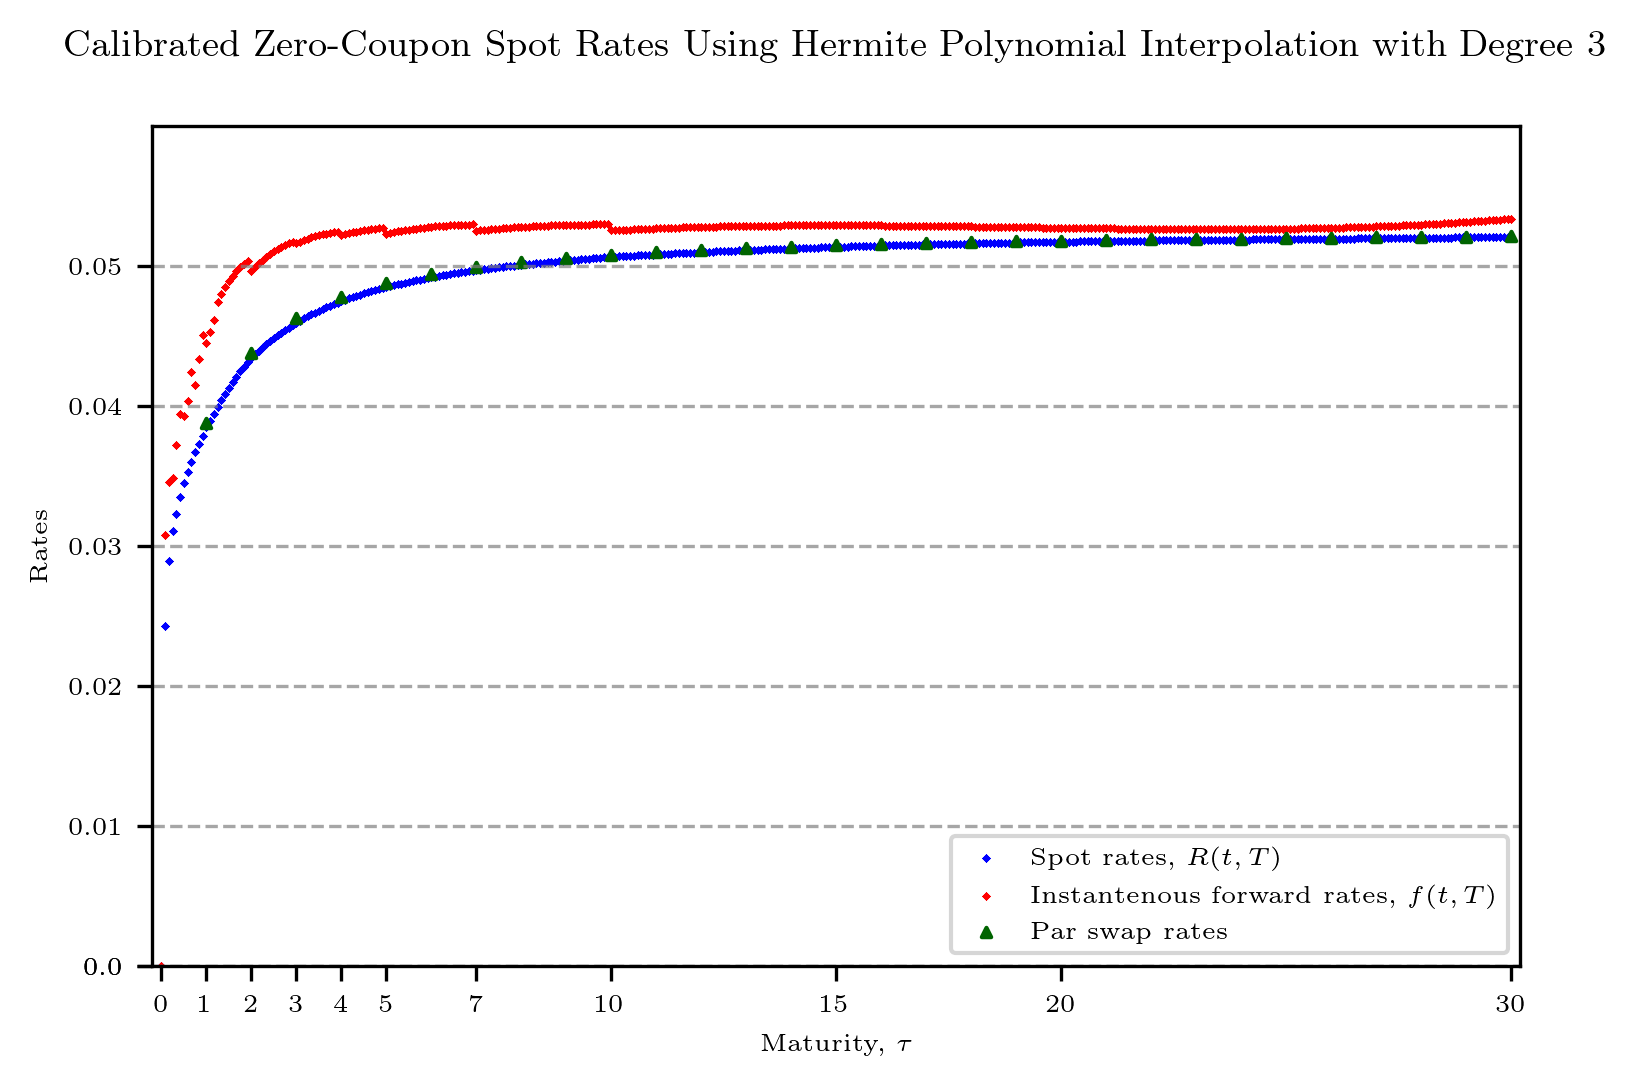

In [16]:
fig = plt.figure(constrained_layout=False, dpi = 300, figsize = (6,4))   #
fig.suptitle(f"Calibrated Zero-Coupon Spot Rates Using Hermite Polynomial Interpolation with Degree 3", fontsize = 9)
gs = fig.add_gridspec(nrows=1,ncols=1,left=0.12,bottom=0.2,right=0.88,top=0.90,wspace=0,hspace=0)
ax = fig.add_subplot(gs[0,0])

xticks = [0,1,2,3,4,5,7,10,15,20,30]
ax.set_xticks(xticks)
ax.set_xticklabels(xticks,fontsize = 6)
ax.set_xlim([xticks[0]-0.2,xticks[-1]+0.2])
plt.xlabel(f"Maturity, $\\tau$",fontsize = 6)
ax.set_yticks([0,0.01,0.02,0.03,0.04,0.05,0.0])
ax.set_yticklabels([0,0.01,0.02,0.03,0.04,0.05,0.0],fontsize = 6)
ax.set_ylim([0,0.06])
ax.set_ylabel(f"Rates",fontsize = 6)
ax.grid(axis='y', linestyle='--', color='grey', alpha=0.7)


p1 = ax.scatter(tau_inter_hermite, R_inter_hermite, s=1, color = 'blue', marker = "x",label="Spot rates, $R(t,T)$")
p2 = ax.scatter(tau_inter_hermite, f_inter_hermite, s=1, color = 'red', marker = "x",label="Instantenous forward rates, $f(t,T)$")
p3 = ax.scatter(range(1,31), R_swap_hermite, s=5, color = 'darkgreen', marker = "^", label="Par swap rates")

plots = [p1,p2,p3]
labels = [item.get_label() for item in plots]
ax.legend(plots,labels,loc="lower right",fontsize = 6)
plt.show()

* Hermite is a type of polynomial and degree = 1 is linear interpolation.
* Using hermite makes it more smooth, but still something dissatisfying around 2 years. But higher degree we can smooth more. Maybe better at front end but not as good as back end, thus 2-3 is enought. 

## Risk Management

First, we consider ways to bump the calibrated parameters, i.e. the spot rate curve.

### Bump a Single Point on Spot Rate Curve 

**Steps:**
- 1) Bump appropriate spot rate by adding 0.0001
- 2) Compute ZCB prices
- 3) Compute new accrual factor for the swap
- 4) Compute new par swap rate of the swap
- 5) Compute DV01 by multiplying new accrual factor and change in the par swap rate

**A) Use ZCB term structure for risk management and compute the DV01 of a $10 \mathrm{Y}$ interest rate swap if we bump the each of the $2 \mathrm{Y}$ spot rates by $1 \mathrm{bp}$ up or down** 

In [17]:
swap_market[5]["maturity"]

10

In [18]:
# DV01 when bumping a single point
idx_swap, tau_bump, size_bump = 5, 2, 0.0001 # swap 10Y (ensure correct index!), spot rate 2Y (just plug and play), 1 bp 

R_bump, ZCB_bump = fid.spot_rate_bump(tau_bump, size_bump, tau_inter_hermite, R_inter_hermite.copy(), ZCB_price_inter_hermite.copy())
S_swap_bump = fid.zcb_to_accrual_factor(0, swap_market[idx_swap]["maturity"], "semiannual", tau_inter_hermite,ZCB_bump)
R_swap_bump = fid.zcb_to_par_swap_rate(0, swap_market[idx_swap]["maturity"], "semiannual", tau_inter_hermite,ZCB_bump)

DV01 = (R_swap_bump - swap_market[idx_swap]["rate"])*S_swap_bump
print(f"DV01 for swap: {idx_swap} when bumping at T: {tau_bump} is {10_000*DV01} bps")

DV01 for swap: 5 when bumping at T: 2 is 0.052527610539487304 bps


**B) Use ZCB term structure for risk management and compute the DV01 of a $10 \mathrm{Y}$ interest rate swap if we bump the each of the $5 \mathrm{Y}$ spot rates by $1 \mathrm{bp}$ up or down** 

In [19]:
# DV01 when bumping a single point
idx_swap, tau_bump, size_bump = 5, 5, 0.0001 # swap 10Y (ensure correct index!), spot rate 2Y (just plug and play), 1 bp 

R_bump, ZCB_bump = fid.spot_rate_bump(tau_bump, size_bump, tau_inter_hermite, R_inter_hermite.copy(), ZCB_price_inter_hermite.copy())
S_swap_bump = fid.zcb_to_accrual_factor(0, swap_market[idx_swap]["maturity"], "semiannual", tau_inter_hermite,ZCB_bump)
R_swap_bump = fid.zcb_to_par_swap_rate(0, swap_market[idx_swap]["maturity"], "semiannual", tau_inter_hermite,ZCB_bump)

DV01 = (R_swap_bump - swap_market[idx_swap]["rate"])*S_swap_bump
print(f"DV01 for swap: {idx_swap} when bumping at T: {tau_bump} is {10_000*DV01} bps")

DV01 for swap: 5 when bumping at T: 5 is 0.10560012342903291 bps


**C) Use ZCB term structure for risk management and compute the DV01 of a $10 \mathrm{Y}$ interest rate swap if we bump the each of the $10 \mathrm{Y}$ spot rates by $1 \mathrm{bp}$ up or down** 

In [20]:
# DV01 when bumping a single point
idx_swap, tau_bump, size_bump = 5, 10, 0.0001 # swap 10Y (ensure correct index!), spot rate 2Y (just plug and play), 1 bp 

R_bump, ZCB_bump = fid.spot_rate_bump(tau_bump, size_bump, tau_inter_hermite, R_inter_hermite.copy(), ZCB_price_inter_hermite.copy())
S_swap_bump = fid.zcb_to_accrual_factor(0, swap_market[idx_swap]["maturity"], "semiannual", tau_inter_hermite,ZCB_bump)
R_swap_bump = fid.zcb_to_par_swap_rate(0, swap_market[idx_swap]["maturity"], "semiannual", tau_inter_hermite,ZCB_bump)

DV01 = (R_swap_bump - swap_market[idx_swap]["rate"])*S_swap_bump
print(f"DV01 for swap: {idx_swap} when bumping at T: {tau_bump} is {10_000*DV01} bps")

DV01 for swap: 5 when bumping at T: 10 is 6.182475685113671 bps


Bumping the $2 \mathrm{Y}, 5 \mathrm{Y}$ or $10 \mathrm{Y}$ spot rates up by 1 bp increases the value of the $10 \mathrm{Y}$ payer swap by $0.0525,0.1056$ and 6.1825 bps respectively. Bumping the $2 \mathrm{Y}, 5 \mathrm{Y}$ or $10 \mathrm{Y}$ spot rates down by 1 bp decreases the value of the $10 \mathrm{Y}$ payer swap by $0.0406,0.0938$ and 6.1768 bps respectively. The $10 \mathrm{Y}$ interest rate swap is thus almost solely exposed to changes in the $10 \mathrm{Y}$ spot rate. Also, we notice that up and down moves of the spot rate affects the $10 \mathrm{Y}$ swap almost symmetrically but not quite.

### Bump the Entire Spot Rate Curve

In [21]:
# DV01 when bumping entire curve
idx_swap, size_bump = 5, 0.0001 # swap 10Y (ensure correct index!), (just plug and play), 1 bp 

R_bump, ZCB_bump = fid.spot_rate_bump(tau_inter_hermite, size_bump,tau_inter_hermite,R_inter_hermite.copy(),ZCB_price_inter_hermite.copy())
S_swap_bump = fid.zcb_to_accrual_factor(0, swap_market[idx_swap]["maturity"], "semiannual",tau_inter_hermite,ZCB_bump)
R_swap_bump = fid.zcb_to_par_swap_rate(0, swap_market[idx_swap]["maturity"], "semiannual",tau_inter_hermite,ZCB_bump)

DV01 = (R_swap_bump - swap_market[idx_swap]["rate"])*S_swap_bump
print(f"DV01 for swap: {idx_swap} when bumping the entire spot rate curve is {10_000*DV01} bps")

DV01 for swap: 5 when bumping the entire spot rate curve is 7.944077707250431 bps


Bumping all the spot rates up by 1 bp increases the value of the 10Y payer swap by 7.9441 and
bumping the spot rates down by 1 bp decreases the value of the 10Y payer swap by 7.9395.
Again, the effect of up versus down moves are almost symmetrical but not quite. Notice, most of the effect is on from the 10Y spot rate!

### Bumping the Swap Market Rates

We can also bump the inputs, i.e. the swap_market rates.\
**A) Bump the $2 \mathrm{Y}$ market swap rates by $1 \mathrm{bp}$ up or down.**

In [22]:
# DV01 when bumping a single swap market rate inpu
idx_swap, idx_swap_bump, size_bump = 5, 0, 0.0001 # to find index check swap_market[?]
swap_market_bump = copy.deepcopy(swap_market)
swap_market_bump[idx_swap_bump]["rate"] += size_bump

# need to redo curve fitting as we are changing input!
data_bump = EURIBOR_fixing + fra_market + swap_market_bump
tau_fit_hermite_bump, R_fit_hermite_bump = fid.zcb_curve_fit(data_bump, interpolation_options = {'method':'hermite','degree':3})
ZCB_price_inter_hermite_bump, R_inter_hermite_bump, f_inter_hermite_bump, tau_inter_hermite_bump = fid.zcb_curve_interpolate(tau_fit_hermite_bump,R_fit_hermite_bump,interpolation_options={'method':'hermite','degree':3})

S_swap_bump = fid.zcb_to_accrual_factor(0, swap_market[idx_swap]["maturity"],"semiannual", tau_inter_hermite, ZCB_price_inter_hermite)
R_swap_bump = fid.zcb_to_par_swap_rate(0,swap_market[idx_swap]["maturity"],"semiannual",tau_inter_hermite_bump, ZCB_price_inter_hermite_bump)

DV01 = (R_swap_bump - swap_market[idx_swap]["rate"])*S_swap_bump
print(f"DV01 for swap: {idx_swap} when bumping swap: {idx_swap_bump+2} is {10_000*DV01} bps")

DV01 for swap: 5 when bumping swap: 2 is 0.0028946947095793048 bps


**B) Bump the $5 \mathrm{Y}$ market swap rates by $1 \mathrm{bp}$ up or down.**

In [23]:
# DV01 when bumping a single swap market rate inpu
idx_swap, idx_swap_bump, size_bump = 5, 3, 0.0001 
swap_market_bump = copy.deepcopy(swap_market)
swap_market_bump[idx_swap_bump]["rate"] += size_bump

# need to redo curve fitting as we are changing input!
data_bump = EURIBOR_fixing + fra_market + swap_market_bump
tau_fit_hermite_bump, R_fit_hermite_bump = fid.zcb_curve_fit(data_bump, interpolation_options = {'method':'hermite','degree':3})
ZCB_price_inter_hermite_bump, R_inter_hermite_bump, f_inter_hermite_bump, tau_inter_hermite_bump = fid.zcb_curve_interpolate(tau_fit_hermite_bump,R_fit_hermite_bump,interpolation_options={'method':'hermite','degree':3})

S_swap_bump = fid.zcb_to_accrual_factor(0, swap_market[idx_swap]["maturity"],"semiannual", tau_inter_hermite, ZCB_price_inter_hermite)
R_swap_bump = fid.zcb_to_par_swap_rate(0,swap_market[idx_swap]["maturity"],"semiannual",tau_inter_hermite_bump, ZCB_price_inter_hermite_bump)

DV01 = (R_swap_bump - swap_market[idx_swap]["rate"])*S_swap_bump
print(f"DV01 for swap: {idx_swap} when bumping swap: {idx_swap_bump+2} is {10_000*DV01} bps")

DV01 for swap: 5 when bumping swap: 5 is 0.01945083464901942 bps


**C) Bump the $10 \mathrm{Y}$ market swap rates by $1 \mathrm{bp}$ up or down.**

In [24]:
# DV01 when bumping a single swap market rate inpu
idx_swap, idx_swap_bump, size_bump = 5, 5, 0.0001 
swap_market_bump = copy.deepcopy(swap_market)
swap_market_bump[idx_swap_bump]["rate"] += size_bump

# need to redo curve fitting as we are changing input!
data_bump = EURIBOR_fixing + fra_market + swap_market_bump
tau_fit_hermite_bump, R_fit_hermite_bump = fid.zcb_curve_fit(data_bump, interpolation_options = {'method':'hermite','degree':3})
ZCB_price_inter_hermite_bump, R_inter_hermite_bump, f_inter_hermite_bump, tau_inter_hermite_bump = fid.zcb_curve_interpolate(tau_fit_hermite_bump,R_fit_hermite_bump,interpolation_options={'method':'hermite','degree':3})

S_swap_bump = fid.zcb_to_accrual_factor(0, swap_market[idx_swap]["maturity"],"semiannual", tau_inter_hermite, ZCB_price_inter_hermite)
R_swap_bump = fid.zcb_to_par_swap_rate(0,swap_market[idx_swap]["maturity"],"semiannual",tau_inter_hermite_bump, ZCB_price_inter_hermite_bump)

DV01 = (R_swap_bump - swap_market[idx_swap]["rate"])*S_swap_bump
print(f"DV01 for swap: {idx_swap} when bumping swap: {idx_swap_bump+2} is {10_000*DV01} bps")

DV01 for swap: 5 when bumping swap: 7 is 7.836860729623 bps


Bumping the $2 \mathrm{Y}, 5 \mathrm{Y}$ or $10 \mathrm{Y}$ market swap rates up by $1 \mathrm{bp}$ increases the value of $10 \mathrm{Y}$ payer swap by $0.0029,0.0194$ and 7.8354 bps respectively. Bumping the $2 \mathrm{Y}$ or $5 \mathrm{Y}$ market swap rates down by $1 \mathrm{bp}$ increases the value of $10 \mathrm{Y}$ payer swap by 0.0117 and 0.0007 respectively and finally bumping the $10 \mathrm{Y}$ swap market rate down by $1 \mathrm{bp}$ decreases the values of the $10 \mathrm{Y}$ payer swap by 7.8581 bps.

## PnL

We compute the mark-to-market value of three different swap related derivatives and compute the PnL of each position since inception.

**i) Compute the market value of a $7 \mathrm{Y}$ swap with a notional of 1 entered into a year ago at the swap rate 0.048 . Also, compute the $\mathrm{PnL}$ of this position.**

In [139]:
R_swap = fid.zcb_to_par_swap_rate(tau_fit_hermite[0],tau_fit_hermite[12],'semiannual',tau_fit_hermite, ZCB_fit_hermite)

R_swap

0.08023387916271155

In [143]:
T_curve, R_curve = fid.zcb_curve_fit(data)
p_curve = fid.spot_rates_to_zcb(T_curve,R_curve)

In [157]:
fid.zcb_to_par_swap_rate(0,6,'semiannual',T_curve,p_curve)

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.]])

In [156]:
T_pos, R_pos = 6, 0.048
alpha = 0.5

S_swap = 0 
fid.zcb_to_par_swap_rate(0,6,'semiannual',T_curve,p_curve)
for i in range(0,2*T_pos):
    S_swap += alpha*p_curve[i]
R_swap = (1-p_curve[12])/S_swap
DV01 = (R_swap-R_pos)*S_swap
PnL = (R_swap-R_pos)*S_swap
print(f'PnL of Position: {PnL} in perent, New swap rate: {R_swap}')

PnL of Position: -0.24125556427545278 in perent, New swap rate: 0.007009423022331711


In [35]:
ZCB_fit_hermite

array([0.99797825, 0.99518891, 0.9922649 , 0.98928842, 0.98614977,
       0.98290724, 0.97964421, 0.97629276, 0.97286119, 0.96942491,
       0.96587604, 0.96227133, 0.95867793, 0.95503371, 0.95134183,
       0.91679726, 0.87126051, 0.82700053, 0.78468993, 0.70613657,
       0.60265111, 0.46284975, 0.35540858, 0.20963803])

we are asked to bump entry 59 (i.e. the last entry) with some amount, 0.0001 

the rate goes up, so you go up as you pay fixed, as others pay 1bps more than you!

In [24]:
DV=1 = (R_swap-swap_armetk)*Swap # PnL

SyntaxError: cannot assign to literal (2452874920.py, line 1)

you make 15bps of the notional if entire curve is bumped 1bps

print s_wap to make sure close to duation (or simply accrual factor)

c) say you have position in 30 year swap, suppose par-swap inceases 1 bps. with accrual factor 15 the results 14 is not surprising, remember smei annually!

c) PnL

Notice, there is no 7 year swap. had it been 5 year swap, since we simply could have since it has become a 4 year swap which is in the market quote, 0.4777, there you would change i par_swap rate \times s (so you would just need to compute s). Instead we compuite par swap rate for 6 year. So compute s,R

PnL is positive 0.7%, this makes sense as our buddy entered swap at 4.8% and now the rates are 4.49%, thus he must have made money on the position since he is payer he made money. Had he sold we should change line:
"Pnl 0 (R_swap - R_pos)*S_wap" to "Pnl 0 (R_pos-R_swap)*S_wap"